# Example patient population

This notebook creates the patient population that is used in the England and Wales examples.

## Notebook setup

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from numpy import isclose  # for checking proportions vs targets

In [2]:
dir_output = 'output'

In [3]:
colour_dict = {
    'haemorrhagic': 'grey',
    'lvo': '#0072b2',                # seaborn colorblind blue
    'nlvo': '#d55e00',               # seaborn colorblind orange
    'lvo_no_treatment': '#00517f',   # seaborn colorblind blue darker
    'lvo_ivt_only': '#0072b2',       # seaborn colorblind blue
    'lvo_ivt_mt': '#0093e5',         # seaborn colorblind blue lighter
    'lvo_mt_only': '#00b3ff',        # seaborn colorblind blue lighter 2
    'nlvo_no_treatment': '#d55e00',  # seaborn colorblind orange
    'nlvo_ivt': '#ff7400',           # seaborn colorblind orange lighter
}

## Stroke types

For patients arriving within 6 hours of stroke onset (from [SAMueL-1 book](https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html)):
+ 13.6% have haemorrhagic stroke
+ The remaining strokes are ischaemic. Of these:
  + 29.5% are LVO
  + 70.5% are nLVO

In [4]:
stroke_type_proportions = {
    'haemorrhagic': 0.136,
    'lvo': 0.295 * (1 - 0.136),
    'nlvo': 0.705 * (1 - 0.136)
}

Display the proportions:

In [5]:
pd.Series(stroke_type_proportions)

haemorrhagic    0.13600
lvo             0.25488
nlvo            0.60912
dtype: float64

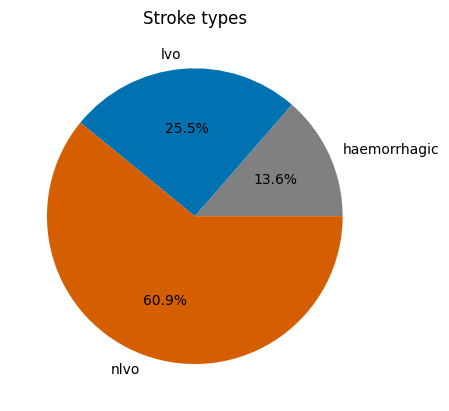

In [8]:
plt.pie(
    stroke_type_proportions.values(),
    labels=stroke_type_proportions.keys(),
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in stroke_type_proportions.keys()]
    )
plt.title('Stroke types')
plt.savefig(os.path.join(dir_output, 'props_stroke_types.png'))
plt.show()

## Treatment

Fix the MT value first because this depends only on LVO.

Patients with NIHSS>10 account for 46.7% of all thrombolysed patients ([from SAMueL-1](https://samuel-book.github.io/samuel-1/descriptive_stats/01a_descriptive_nihss_cutoff.html)).

Multiply this proportion by the target IVT rate:

> 20% $\times$ 46.7% = Proportion of all patients with LVO and IVT

And assign the remaining patients to nLVO:

> 20% $\times$ (100% - 46.7%) = Proportion of all patients with nLVO and IVT

Then account for the fact that most LVO patients receiving MT also receive IVT.

In [9]:
target_ivt = 0.2
target_mt = 0.1
prop_mt_previously_ivt = 0.85

prop_ivt_lvo = 0.467

### nLVO

In [10]:
prop_nlvo_ivt = target_ivt * (1.0 - prop_ivt_lvo) / stroke_type_proportions['nlvo']

Display the proportions:

In [12]:
nlvo_proportions = {
    'nlvo_no_treatment': (1.0 - prop_nlvo_ivt),
    'nlvo_ivt': prop_nlvo_ivt,
}

In [13]:
pd.Series(nlvo_proportions)

nlvo_no_treatment    0.824993
nlvo_ivt             0.175007
dtype: float64

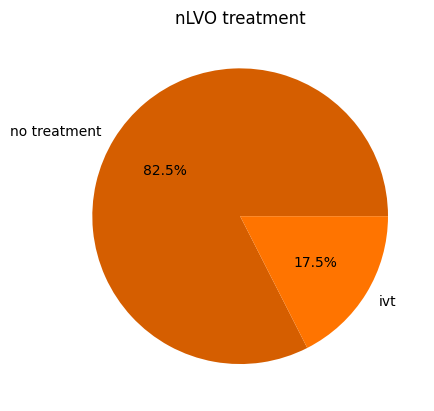

In [31]:
plt.pie(
    nlvo_proportions.values(),
    labels=[c.split('nlvo_')[1].replace('_', ' ') for c in nlvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in nlvo_proportions.keys()]
    )
plt.title('nLVO treatment')
plt.savefig(os.path.join(dir_output, 'props_nlvo.png'))
plt.show()

### LVO

Only LVO is treated with MT, so to hit the target value of 10% we need:

> Proportion LVO $\times$ Proportion of LVO treated with MT = 10%

Rearranging:

> Proportion of LVO treated with MT = 10% / Proportion LVO

In [15]:
prop_lvo_mt = target_mt / stroke_type_proportions['lvo']

Then set the overlap between IVT and MT for LVO patients:

In [17]:
prop_lvo_ivtmt = prop_lvo_mt * prop_mt_previously_ivt

Find the LVO patients treated with IVT:

In [18]:
prop_lvo_ivt = (target_ivt * prop_ivt_lvo) / stroke_type_proportions['lvo']

Compare values:

In [19]:
print(prop_lvo_mt, prop_lvo_ivtmt, prop_lvo_ivt)

0.39234149403640933 0.33349026993094794 0.3664469554300063


Subtract the overlap:

In [20]:
prop_lvo_mtonly = prop_lvo_mt - prop_lvo_ivtmt
prop_lvo_ivtonly = prop_lvo_ivt - prop_lvo_ivtmt

Display the LVO proportions:

In [21]:
lvo_proportions = {
    'lvo_no_treatment': (1.0 - prop_lvo_mt - prop_lvo_ivtonly),
    'lvo_ivt_only': prop_lvo_ivtonly,
    'lvo_ivt_mt': prop_lvo_ivtmt,
    'lvo_mt_only': prop_lvo_mtonly,
}

In [22]:
pd.Series(lvo_proportions)

lvo_no_treatment    0.574702
lvo_ivt_only        0.032957
lvo_ivt_mt          0.333490
lvo_mt_only         0.058851
dtype: float64

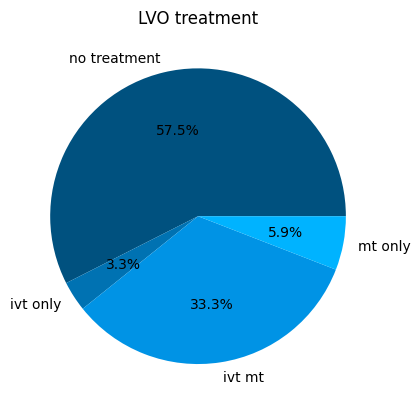

In [32]:
plt.pie(
    lvo_proportions.values(),
    labels=[c.split('lvo_')[1].replace('_', ' ') for c in lvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in lvo_proportions.keys()]
    )
plt.title('LVO treatment')
plt.savefig(os.path.join(dir_output, 'props_lvo.png'))
plt.show()

## Whole population breakdown

In [37]:
pop_proportions = {
    'haemorrhagic': stroke_type_proportions['haemorrhagic'],
    'lvo_no_treatment': stroke_type_proportions['lvo'] * lvo_proportions['lvo_no_treatment'],
    'lvo_ivt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_only'],
    'lvo_ivt_mt': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_mt'],
    'lvo_mt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_mt_only'],
    'nlvo_no_treatment': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_no_treatment'],
    'nlvo_ivt': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_ivt'],
}

# Round values to 5 decimal places:
for key, value in pop_proportions.items():
    pop_proportions[key] = round(value, 5)

In [38]:
pd.Series(pop_proportions)

haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
dtype: float64

### Sanity checks

Do all proportions add up to 1?

In [39]:
pd.Series(pop_proportions).sum()

1.0

Check that the treated proportions match the targets:

In [40]:
prop_ivt = 0.0
prop_mt = 0.0

for key, value in pop_proportions.items():
    if 'ivt' in key:
        prop_ivt += value
    if 'mt' in key:
        prop_mt += value

In [41]:
print('IVT:', prop_ivt, isclose(prop_ivt, target_ivt))
print('MT:', prop_mt, isclose(prop_mt, target_mt))

IVT: 0.2 True
MT: 0.1 True


Check that the stroke type subgroups add up to the total stroke type sizes:

In [42]:
prop_lvo = 0.0
prop_nlvo = 0.0

for key, value in pop_proportions.items():
    if 'nlvo' in key:
        prop_nlvo += value
    elif 'lvo' in key:
        prop_lvo += value

In [43]:
print('LVO:', prop_lvo, isclose(prop_lvo, stroke_type_proportions['lvo']))
print('nLVO:', prop_nlvo, isclose(prop_nlvo, stroke_type_proportions['nlvo']))

LVO: 0.25488 True
nLVO: 0.60912 True


### Plot

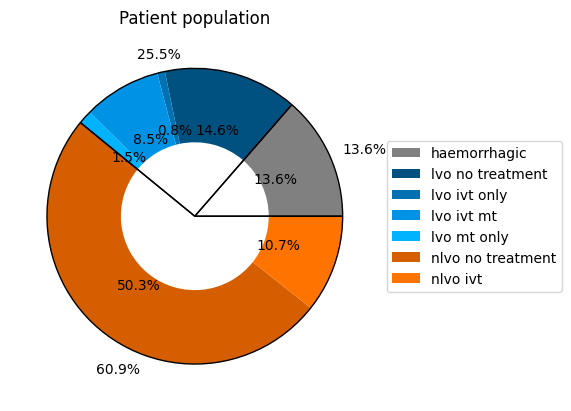

In [44]:
fig, ax = plt.subplots()

# Draw each cohort/treatment subgroup in a different colour
# and write the size on the wedge.
wedges, texts, autotexts = ax.pie(
    pop_proportions.values(),
    autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=0.5),
    colors=[colour_dict[c] for c in pop_proportions.keys()]
    )

# Outline LVO, nLVO and haemorrhagic sections
# and add labels outside each section.
ax.pie(
    stroke_type_proportions.values(),
    labels=[f'{c:.1%}' for c in stroke_type_proportions.values()],
    # autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=1.0, edgecolor='k'),
    colors=['None'] * len(stroke_type_proportions),
    )

ax.legend(
    wedges, [c.replace('_', ' ') for c in pop_proportions.keys()],
    bbox_to_anchor=[1.0, 0.5], loc='center left'
)

plt.title('Patient population')
plt.savefig(os.path.join(dir_output, 'props_all.png'))
plt.show()

### Save population proportions to file

In [46]:
pd.Series(pop_proportions).to_csv(os.path.join(dir_output, 'patient_proportions.csv'), header=False)